In [1]:
import cv2
import logging
import math
import numpy as np
import matplotlib.pyplot as plt

(300, 400, 3)
AxesImage(54,36;334.8x217.44)


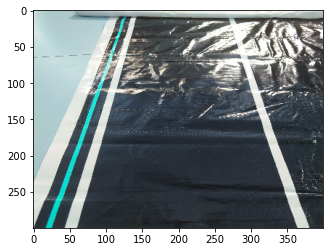

In [2]:
#img=cv2.imread('D://lane1.jpeg')
img=cv2.imread('D:\\project images/img1.jpg')
image=cv2.resize(img, (400,300)) #weidth, height
print(image.shape)
print(plt.imshow(image))

In [63]:
#img=cv2.cvtColor(image,cv2.COLOR_BGR2HLS)
#someimg = (img[:,:,1] >200)*(img[:,:,0] >200)*(img[:,:,2] >200)
#plt.imshow(img)

In [3]:
def detect_edges(image):
    hls=cv2.cvtColor(image,cv2.COLOR_BGR2HLS)
    lower_blue = np.array([0, 210, 0], dtype=np.uint8) #[0,200,0]
    upper_blue = np.array([180, 255, 255], dtype=np.uint8)
    mask = cv2.inRange(hls, lower_blue, upper_blue)
    kernel_size = 1
    blur_gray = cv2.GaussianBlur(mask,(kernel_size, kernel_size), 0)
    edges = cv2.Canny(mask, 50, 150)
    plt.imshow(edges)
    return edges

numpy.ndarray

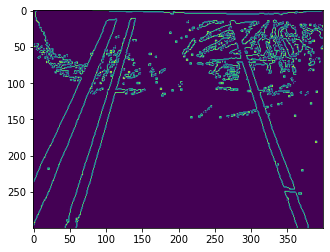

In [4]:
edges=detect_edges(image)
plt.imshow(edges)
type(edges)

In [5]:
#region of interest
height = edges.shape[0]
width = edges.shape[1]

def region_of_interest(edges):
    mask = np.zeros_like(edges)
    vertics=np.array([[(80, height*1/2),(width, height*1/2),(width, height),(0,height),]],np.int32)
    #channel=(255,)*img.shape[2]
    cv2.fillPoly(mask, vertics, 255)
    cropped_edges = cv2.bitwise_and(edges, mask)
    return cropped_edges

AxesImage(54,36;334.8x217.44)


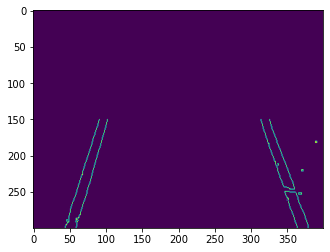

In [6]:
cropped_edges=region_of_interest(edges)
print(plt.imshow(cropped_edges))

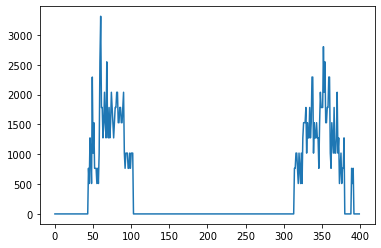

In [7]:
histogram = np.sum(cropped_edges[cropped_edges.shape[0]//2:,:], axis=0)
plt.plot(histogram)

In [8]:
def detect_line_segments(cropped_edges):
    # tuning min_threshold, minLineLength, maxLineGap is a trial and error process by hand
    rho = 1  # distance precision in pixel, i.e. 1 pixel
    angle = np.pi / 180  # angular precision in radian, i.e. 1 degree
    min_threshold = 5  # minimal of votes
    lines=np.array([])
    line_segments = cv2.HoughLinesP(cropped_edges, rho, angle, min_threshold, 
                                    lines, minLineLength=20, maxLineGap=20)
    return line_segments

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[ 44 299  90 155]]

 [[329 163 379 295]]

 [[ 71 261 102 153]]

 [[316 159 364 299]]

 [[ 59 290  68 270]]

 [[ 81 181  91 150]]

 [[314 150 364 297]]

 [[326 152 359 240]]

 [[ 48 292  52 270]]

 [[358 246 379 296]]

 [[ 59 299 102 150]]

 [[ 54 264  60 294]]

 [[350 249 370 252]]

 [[338 211 343 237]]]
AxesImage(54,36;334.8x217.44)


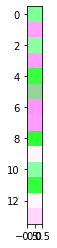

In [9]:
line_segments=detect_line_segments(cropped_edges)
print(line_segments)
print(plt.imshow(line_segments))

In [10]:
def display_lines(image,dum_lines,line_color=(255, 0, 0), line_width=10):
    blank_image=np.zeros_like(image)
    if dum_lines is not None:
        for line in dum_lines:
            for x1,y1,x2,y2 in line:
                cv2.line(blank_image, (x1,y1), (x2,y2), line_color,line_width)
    color_edges = np.dstack((edges, edges, edges)) 
    line_image=cv2.addWeighted(color_edges, 0.8, blank_image, 1, 0)
    return line_image

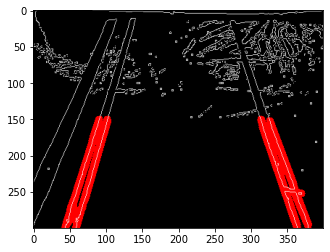

In [11]:
detectedlines=display_lines(image,line_segments)
#print(detectedlines)
plt.imshow(detectedlines)

In [12]:
def make_points(frame, line):
    #making line in between the road lines to showing angle
    height, width, _ = frame.shape
    slope, intercept = line
    y1 = height  # bottom of the frame
    y2 = int(y1 * 1 / 2)  # make points from middle of the frame down

    # bound the coordinates within the frame
    x1 = max(-width, min(2 * width, int((y1 - intercept) / slope)))
    x2 = max(-width, min(2 * width, int((y2 - intercept) / slope)))
    return [[x1, y1, x2, y2]]

In [13]:
def average_slope_intercept(frame, line_segments):
    """
    This function combines line segments into one or two lane lines
    If all line slopes are < 0: then we only have detected left lane
    If all line slopes are > 0: then we only have detected right lane
    """
    lane_lines = []
    if line_segments is None:
        logging.info('No line_segment segments detected')
        return lane_lines

    height, width, _ = frame.shape
    left_fit = []
    right_fit = []

    boundary = 1/3
    left_region_boundary = width * (1 - boundary)  # left lane line segment should be on left 2/3 of the screen
    right_region_boundary = width * boundary # right lane line segment should be on left 2/3 of the screen

    for line_segment in line_segments:
        for x1, y1, x2, y2 in line_segment:
            if x1 == x2:
                logging.info('skipping vertical line segment (slope=inf): %s' % line_segment)
                continue
            fit = np.polyfit((x1, x2), (y1, y2), 1)
            slope = fit[0]
            intercept = fit[1]
            if slope < 0:
                if x1 < left_region_boundary and x2 < left_region_boundary:
                    left_fit.append((slope, intercept))
            else:
                if x1 > right_region_boundary and x2 > right_region_boundary:
                    right_fit.append((slope, intercept))

    left_fit_average = np.average(left_fit, axis=0)
    if len(left_fit) > 0:
        lane_lines.append(make_points(frame, left_fit_average))

    right_fit_average = np.average(right_fit, axis=0)
    if len(right_fit) > 0:
        lane_lines.append(make_points(frame, right_fit_average))

    logging.debug('lane lines: %s' % lane_lines)  # [[[316, 720, 484, 432]], [[1009, 720, 718, 432]]]

    return lane_lines

In [14]:
intercepts=average_slope_intercept(image, line_segments)
intercepts

[[[50, 300, 93, 150]], [[371, 300, 315, 150]]]

In [15]:
def detect_lane(frame):
    
    edges = detect_edges(frame)
    cropped_edges = region_of_interest(edges)
    line_segments = detect_line_segments(cropped_edges)
    lane_lines = average_slope_intercept(frame, line_segments)
    print(type(lane_lines))

    return lane_lines

<class 'list'>
[[[50, 300, 93, 150]], [[371, 300, 315, 150]]]


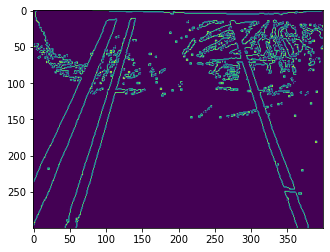

In [16]:
lane_lines=detect_lane(image)
#type(lane_lines)
print(lane_lines)

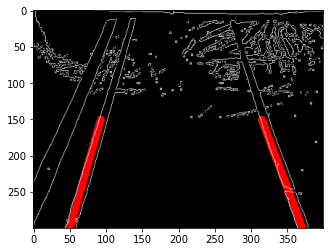

In [17]:
#img=cv2.cvtColor(lane1,cv2.COLOR_BGR2HLS)
linesfit=display_lines(image,lane_lines)
plt.imshow(linesfit)

In [18]:
height, width, _ = image.shape
_, _, left_x2, _ = lane_lines[0][0]
print(left_x2)
_, _, right_x2, _ = lane_lines[1][0]
print(right_x2)
mid = int(width / 2)
print(mid)
x_offset = (left_x2 + right_x2) / 2 - mid
print(x_offset)

93
315
200
4.0


In [19]:
x1, _, x2, _ = lane_lines[0][0]
x_offset = x2 - x1
print(x_offset)
y_offset = int(height / 2)
print(y_offset)

43
150


In [20]:
angle_to_mid_radian = math.atan(x_offset / y_offset)  # angle (in radian) to center vertical line
print(angle_to_mid_radian)
angle_to_mid_deg = int(angle_to_mid_radian * 180.0 / math.pi)  # angle (in degrees) to center vertical line
print(angle_to_mid_deg)
steering_angle = angle_to_mid_deg + 90  # this is the steering angle needed by picar front wheel
print(steering_angle)

0.27917994046787675
15
105


In [25]:
def display_heading_line(frame, steering_angle, line_color=(0, 255, 0), line_width=5 ):
    heading_image = np.zeros_like(frame)
    height, width, _ = frame.shape

    # figure out the heading line from steering angle
    # heading line (x1,y1) is always center bottom of the screen
    # (x2, y2) requires a bit of trigonometry

    # Note: the steering angle of:
    # 0-89 degree: turn left
    # 90 degree: going straight
    # 91-180 degree: turn right 
    steering_angle_radian = steering_angle / 180.0 * math.pi
    print(steering_angle_radian)
    x1 = int(width / 2)
    y1 = height
    x2 = int(x1 - height / 2 / math.tan(steering_angle_radian))
    print(x2)
    y2 = int(height / 2)

    cv2.line(heading_image, (x1, y1), (x2, y2), line_color, line_width)
    heading_image = cv2.addWeighted(frame, 0.8, heading_image, 1, 1)

    return heading_image

1.8325957145940461
240


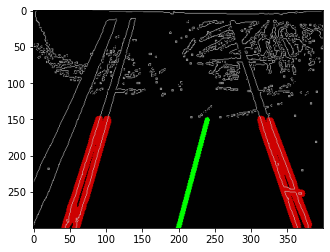

In [33]:
import logging
#color_edges = np.dstack((edges, edges, edges)) 
dhl=display_heading_line(detectedlines, steering_angle)
#console.log('asd')
plt.imshow(dhl)

In [23]:
def stabilize_steering_angle(
          curr_steering_angle, 
          new_steering_angle, 
          num_of_lane_lines, 
          max_angle_deviation_two_lines=5, 
          max_angle_deviation_one_lane=1):
    """
    Using last steering angle to stabilize the steering angle
    if new angle is too different from current angle, 
    only turn by max_angle_deviation degrees
    """
    if num_of_lane_lines == 2 :
        # if both lane lines detected, then we can deviate more
        max_angle_deviation = max_angle_deviation_two_lines
    else :
        # if only one lane detected, don't deviate too much
        max_angle_deviation = max_angle_deviation_one_lane
    
    angle_deviation = new_steering_angle - curr_steering_angle
    if abs(angle_deviation) > max_angle_deviation:
        stabilized_steering_angle = int(curr_steering_angle
            + max_angle_deviation * angle_deviation / abs(angle_deviation))
    else:
        stabilized_steering_angle = new_steering_angle
    return stabilized_steering_angle